# Convolution Theorem

In [94]:
import numpy as np
import matplotlib.pylab as pl
import scipy.linalg as sp
import scipy.fftpack as sf
import time

The convolution theorem states that the Fourier transform of the convolution of two signals will be equivalent to the multiplication of those signals in the Fourier domain. For example, if you take two time-streams of data and convolve them with each other, that would be the same as if you Fourier transformed those signals into frequency space and then multiplied them together.

Let's test this out. First, let's take two signals -- identical aside from a time delay. This is a situation you may encounter if there's a difference in cable lengths between two sources of the same signal (spoiler alert: this will come up in lab 3).

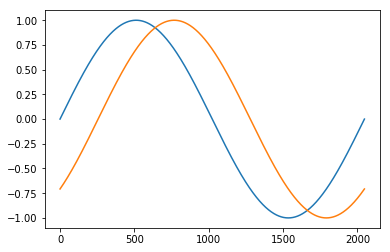

In [82]:
tau = np.pi/4. # delay between two signals
signal1 = np.sin(np.linspace(0, 2*np.pi, 2048))
signal2 = np.sin(np.linspace(0, 2*np.pi, 2048)-tau)

pl.plot(signal1)
pl.plot(signal2)

Now let's verify that the convolution theorem holds. First, we will take our two signals and convolve them, then take the Fourier transform of the convolved signal.

In [83]:
# first, center time using an FFT shift
signal1 = sf.fftshift(signal1)
signal2 = sf.fftshift(signal2)


# convolve time streams and FT
c = np.convolve(signal1, signal2)
fc = np.fft.fft(c)

Now we'll try the other side of the equation, by first Fourier transforming our signals and multiplying them together. Before we can do this, we must copy our signals into a new array that's twice as long and has been padded with zeros. This is because the convolution operation slides over the full length of both signals, doubling the array size.

In [84]:
# copy and pad signals with zeros to fit new array shape
s1 = signal1.copy()
s1.resize(len(c), refcheck=False)

s2 = signal2.copy()
s2.resize(len(c), refcheck=False)

# Fourier transform signals into frequency space
fs1 = np.fft.fft(s1)
fs2 = np.fft.fft(s2)

# multiply FT signals
m = fs1 * fs2

Now we'll take both our convolved-and-Fourier-transformed signal and our Fourier-transformed-and-multiplied signal and compare. If the convolution theorem is true, then these two signals should be identical.

In [85]:
# compare convolution vs. FT + multiplication, show that difference is less than numerical noise
if (abs(fc - m) < 1e-8).all():
    print "Convolution theorem holds!"
else:
    print "Oh no."

Convolution theorem holds!


# The Fast Fourier Transform

Earlier in this tutorial, you learned about the discrete Fourier transform (DFT) -- the way that computers are able to calculate Fourier transforms using discrete time and voltage samples. We also hinted that there's a benefit to performing your FTs with two specific characteristics:

1. You want your number of samples to be a power of two.
2. You want to define your time range so that the center point is $t = 0$.

The reason for this is that it optimizes your data for usage with the Fast Fourier Transform (FFT), a specific algorithm for performing the DFT. The details of the FFT are complicated and generally left to those who specialize in the development of such algorithms, but the basic layout is that a complex input signal with N samples is broken down into two sets of N/2 samples, and then broken down again into four sets of N/4 samples, and again and again until you are left with N interlaced sets of 1 complex sample each. This is all to say: we reorder our samples in a convenient fashion. Those samples are then set into frequency space (recall: the FT of one point is itself, so nothing really happens in this stage computationally). The last step is to combine the N frequency spectra we now have in the exact reverse order of the time domain decomposition described above, one stage at a time.

If that was confusing, don't worry! Understanding the algorithmic ins-and-outs of the FFT is purely optional for scientists like us. All that we need to know is that it's much, much faster than a classic DFT operation. Where the DFT is an O($N^2$) operation, the FFT is an O($N\log{N}$) operation. Once you get into large data sets, this can save a lot of time in your data analysis.

Let's take a look at how long it would take to perform a classic DFT vs. an FFT on a nicely shaped data set (where $N_{sample}$ is a power of two)

In [92]:
N = 2048 # number of samples in signal
sig = sf.fftshift(np.random.randn(N)) # center t = 0

# first compute DFT and see how long it takes to run
start_time = time.time()
dft = sp.dft(N)
dft_sig = dft.dot(sig)
stop_time = time.time()

dft_time = stop_time - start_time

print "DFT computation time: %f" % (dft_time)

# now compute FFT and see how long that takes
start_time = time.time()
fft_sig = np.fft.fft(sig)
stop_time = time.time()

fft_time = stop_time - start_time

print "FFT computation time: %f" % (fft_time)

print "FFT is %d times faster than DFT." % int(dft_time/fft_time)

# show that DFT and FFT are equivalent operations mathematically
print "\nAre FFT and DFT giving the same results?"
print (abs(dft_sig-fft_sig) < 1e-8).all()

DFT computation time: 2.200099
FFT computation time: 0.000388
FFT is 5671 times faster than DFT.

Are FFT and DFT giving the same results?
True


We've now seen that the FFT is a much more efficient algorithm than the DFT. But what happens if our input signal isn't idealized for FFT usage? 

Let's compare an idealized FFT (what we always aim for as radio astronomers) vs. non-ideal FFT. We'll do this by doing one FFT with two spectra -- one with a prime number of samples and one with a power of two. These are respectively the slowest and fastest cases of the FFT.

To give an advantage to the prime number case, we'll let the prime number be slightly lower than the power of two we're using. Let's see how long it takes to calculate these two cases of the FFT.

In [93]:
sig1 = sf.fftshift(np.random.randn(4096)) # power of two number of samples -- most ideal for FFT calculation
sig2 = sf.fftshift(np.random.randn(4093)) # prime number of samples -- least ideal for FFT calculation

# now compute FFT on array with nice number of samples and see how long that takes
start_time = time.time()
fft_sig = np.fft.fft(sig1)
stop_time = time.time()

fft_time_ideal = stop_time - start_time

print "FFT computation time, N = power of two: %f" % (fft_time_ideal)

# now compute FFT on array with bad number of samples and see how long that takes
start_time = time.time()
fft_sig = np.fft.fft(sig2)
stop_time = time.time()

fft_time_prime = stop_time - start_time

print "FFT computation time, N = prime number: %f" % (fft_time_prime)

print "Ideal FFT is %d times faster than the prime number FFT." % int(fft_time_prime / fft_time_ideal)

FFT computation time, N = power of two: 0.001342
FFT computation time, N = prime number: 0.077139
Ideal FFT is 57 times faster than the prime number FFT.


Even with fewer samples, the FFT with a prime number of samples takes much longer to compute that the FFT with a number of samples that's a power of two!